Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [27]:
import convex_return_mapping as crm
import cvxpy as cp

In [28]:
import meshio
import numpy as np

import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells, compute_collisions)
import time
import basix

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

# defining function to interpolate function defined over quadrature elements
def interpolate_quadrature(ufl_expr, fem_func):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    fem_func.x.scatter_forward()

In [29]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [30]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [31]:
# elastic parameters
sig0_dim = 250. #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim #[-]
nu = 0.3 #[-]
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))
# sig0 = fem.Constant(mesh, PETSc.ScalarType(250))  # yield strength 250
sig0 = 250 / sig0_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

In [32]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
WTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=(4, 4), quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)
WT = fem.FunctionSpace(mesh, WTe)

In [33]:
sig = fem.Function(W)
sig_old = fem.Function(W)
n_elas = fem.Function(W)
beta = fem.Function(W0)
p = fem.Function(W0, name="Cumulative_plastic_strain")
p_old = fem.Function(W0, name="Cumulative_plastic_strain")
dp = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
# sig_eq = fem.Function(W0, name="sig_eq")
# f_elas = fem.Function(W0, name="sig_eq")
C_tang = fem.Function(WT)

deps = fem.Function(W, name="deps")

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

# zero_Du = fem.Function(V)

In [34]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [35]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)

loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

SQRT2 = np.sqrt(2.)

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def eps_vec(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_vector([e[0, 0], e[1, 1], 0, SQRT2 * e[0, 1]])

def sigma(eps_el):
    return lmbda*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu*eps_el

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3]/SQRT2, 0],
                          [X[3]/SQRT2, X[1], 0],
                          [0, 0, X[2]]])

# ppos = lambda x: (x + ufl.sqrt(x**2))/2.
# def proj_sig(deps, old_sig, old_p):
#     sig_n = as_3D_tensor(old_sig)
#     sig_elas = sig_n + sigma(deps)
#     s = ufl.dev(sig_elas)
#     sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
#     f_elas = sig_eq - sig0 - H*old_p
#     dp = ppos(f_elas)/(3*mu+H)
#     n_elas = s/sig_eq*ppos(f_elas)/f_elas
#     beta = 3*mu*dp/sig_eq
#     new_sig = sig_elas-beta*s
#     return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
#            ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
#            beta, dp, sig_eq, f_elas         

def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu*beta*ufl.dev(e)  

In [36]:
vonMises = crm.vonMises(sig0, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)
n_quadrature_points = len(C_tang.x.array.reshape((-1, 4, 4)))
for i in range(n_quadrature_points):
    C_tang.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

In [37]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps_vec(v), ufl.dot(C_tang, eps_vec(u_)))*dx 
# a_Newton = ufl.inner(eps(v), sigma_tang(eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

def project(original_field, target_field, bcs=[]):
    # original_field -> target_field
    # Ensure we have a mesh and attach to measure
    V = target_field.function_space

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = fem.form(ufl.inner(Pv, w) * dx)
    L = fem.form(ufl.inner(original_field, w) * dx)

    # Assemble linear system
    A = fem.petsc.assemble_matrix(a, bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)
    fem.petsc.apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_field.vector)  
    target_field.x.scatter_forward()


In [38]:
problem = fem.petsc.LinearProblem(
    a_Newton,
    res,
    bcs=bcs,
    petsc_options={
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

form_res = fem.form(res)
form_a_Newton = fem.form(a_Newton)

b = fem.petsc.create_vector(form_res)
A = fem.petsc.create_matrix(form_a_Newton)

with b.localForm() as b_local:
    b_local.set(0.0)
fem.petsc.assemble_vector(b, form_res)
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
fem.set_bc(b, bcs)

A.zeroEntries()
fem.petsc.assemble_matrix(A, form_a_Newton, bcs=bcs)
A.assemble()

solver = PETSc.KSP().create(mesh.comm)
solver.setType("preonly")
solver.getPC().setType("lu")
solver.setOperators(A)

In [39]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u

cells = []
points_on_proc = []
x_point = np.zeros((1, 3))
x_point[0][0] = Ri
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
cell_candidates = compute_collisions(tree, x_point)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, x_point)
for i, point in enumerate(x_point):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [40]:
class ReturnMapping:
    def __init__(self, material, solver=cp.SCS):
        self.material = material
        self.deps = cp.Parameter((4,))
        self.sig_old = cp.Parameter((4,))
        self.sig_elas = self.sig_old + self.material.C @ self.deps
        self.sig = cp.Variable((4,))
        
        self.p_old = cp.Parameter(nonneg=True)
        self.theta_elas = self.p_old * vonMises.H.value
        self.theta = cp.Variable(nonneg=True)
        self.p = self.theta / vonMises.H.value

        # self.dp = cp.Parameter(nonneg=True) 

        self.sig_old.value = np.zeros((4,))
        self.deps.value = np.zeros((4,))
        self.p_old.value = 0

        target_expression = cp.quad_form(self.sig - self.sig_elas, np.linalg.inv(self.material.C)) + cp.square(self.theta - self.theta_elas) / vonMises.H.value
        # target_expression = cp.sum_squares(self.sig - self.sig_elas) + cp.square(self.theta - self.theta_elas) / vonMises.H.value
        # /vonMises.H.value

        # tmp_expr = cp.sum_squares(self.theta - self.theta_elas) 
        # tmp_expr2 = (cp.square(self.theta) - cp.square(self.theta_elas))
        # print(target_expression.is_dcp(dpp=True))
        # print(self.p.sign)
        
        self.constrains = material.criterion(self.sig, self.p_old, self.theta_elas)

        if self.material.plane_stress:
            self.constrains.append(self.sig[2] == 0)

        self.opt_problem = cp.Problem(cp.Minimize(target_expression))
        print(self.opt_problem.is_dcp(dpp=True))
        # print(self.opt_problem.is_dgp(dpp=True))
        self.solver = solver
        
    def solve(self, **kwargs):
        self.opt_problem.solve(solver=self.solver, requires_grad=True, **kwargs)
        # print("status:", self.opt_problem.status)
        # print("optimal value", self.opt_problem.value)
        # self.dp.value = self.p.value - self.p_old.value
        # self.sig_old.value = self.sig.value
        # self.dp_old.value = self.p.value

        self.C_tang = np.zeros((4, 4))
        for i in range(4):
            z = np.zeros((4,))
            z[i] = 1
            self.deps.delta = z
            self.opt_problem.derivative()
            self.C_tang[i, :] = self.sig.delta 
    
return_mapping = ReturnMapping(material)
# return_mapping.sig_old.value = np.zeros((4,))
# return_mapping.p_old.value = 0.

True


In [41]:
    # sig_n = as_3D_tensor(old_sig)
    # sig_elas = sig_n + sigma(deps)
    # s = ufl.dev(sig_elas)
    # sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    # f_elas = sig_eq - sig0 - H*old_p
    # dp = ppos(f_elas)/(3*mu+H)
    # n_elas = s/sig_eq*ppos(f_elas)/f_elas
    # beta = 3*mu*dp/sig_eq
    # new_sig = sig_elas-beta*s
    # return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
    #        ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
    #        beta, dp, sig_eq, f_elas   

In [42]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
load_steps = load_steps
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
p_old.vector.set(0.0)
u.vector.set(0.0)
n_elas.vector.set(0.0)
beta.vector.set(0.0)
n_quadrature_points = len(C_tang.x.array.reshape((-1, 4, 4)))
for i in range(n_quadrature_points):
    C_tang.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

print('C_tang', np.max(C_tang.x.array), np.min(C_tang.x.array))

start = time.time()

for (i, t) in enumerate(load_steps[:1]):
    loading.value = t * q_lim

    with b.localForm() as b_local:
        b_local.set(0.0)
    b = fem.petsc.assemble_vector(form_res)
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.set_bc(b, bcs)

    nRes0 = b.norm() # Which one? - ufl.sqrt(Res.dot(Res))
    nRes = nRes0
    Du.vector.set(0.0)
    Du.x.scatter_forward()

    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
    niter = 0

    print('b-A', b.norm(), A.norm())

    while nRes/nRes0 > tol and niter < Nitermax:
        solver.solve(b, du.vector)
        print('du', np.max(du.x.array), np.min(du.x.array), du.vector.norm())

        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 
        # print(du.x.array[:])
        interpolate_quadrature(eps_vec(Du), deps) # eps_xy * sqrt(2.)!
        deps_values = deps.x.array.reshape((-1, 4))
        for q in range(n_quadrature_points):
            return_mapping.deps.value[:] = deps_values[q,:]
            return_mapping.sig_old.value[:] = sig_old.x.array.reshape((-1, 4))[q,:]
            return_mapping.p_old.value = p_old.x.array[q]
            # print(sig_old.x.array.reshape((-1, 4))[i,:], deps[i,:])
            start_conv = time.time()
            return_mapping.solve(eps=1e-10, alpha=1.8, scale=5.)
            #, eps_abs=1e-13, eps_rel=1e-13

# T.vector.norm - bug, where T is a tensor???

            end_conv = time.time()

            sig.x.array.reshape((-1, 4))[q,:] = return_mapping.sig.value[:]
            # sig.x.array.reshape((-1, 4))[q,3] /= np.sqrt(2.)
            p.x.array[q] = return_mapping.p.value
            C_tang.x.array.reshape((-1, 4, 4))[q,:,:] = return_mapping.C_tang[:,:]
            # dp.x.array[i] = return_mapping.dp.value
        
        # print('sig', np.max(sig.x.array), np.min(sig.x.array), np.mean(sig.x.array))
        # print(sig.x.array)
        print('p', np.max(p.x.array), np.min(p.x.array), p.vector.norm())
        print('C_tang', np.max(C_tang.x.array), np.min(C_tang.x.array))


        # deps = eps(Du)
        # sig_, n_elas_, beta_, dp_, sig_eq_, f_elas_ = proj_sig(deps, sig_old, p)

        # interpolate_quadrature(sig_, sig)
        # interpolate_quadrature(n_elas_, n_elas)
        # interpolate_quadrature(beta_, beta)

        # interpolate_quadrature(dp_, dp)
        # interpolate_quadrature(sig_eq_, sig_eq)
        # interpolate_quadrature(f_elas_, f_elas)
        
        A.zeroEntries()
        fem.petsc.assemble_matrix(A, form_a_Newton, bcs=bcs)
        A.assemble()
        with b.localForm() as b_local:
            b_local.set(0.0)
        fem.petsc.assemble_vector(b, form_res)
        print('b-A', b.norm(), A.norm())
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.set_bc(b, bcs)
        # print('b', b.norm())

        nRes = b.norm() 
        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    # interpolate_quadrature(dp_, dp)
    # p.vector.axpy(1, dp.vector)
    p.vector.copy(p_old.vector)
    p.x.scatter_forward()
    
    sig.vector.copy(sig_old.vector)
    sig.x.scatter_forward()

    # project(p, p_avg)
    # p_avg.x.scatter_forward()
    
    # xdmf.write_function(u, t)
    # xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

# xdmf.close()
end = time.time()
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {end-start:.3f} (s)')

C_tang 1.346153846153846 0.0

nRes0 , 4.0766891205717435e-05 
 Increment: 1, load = 0.0002537449238735671
b-A 4.0766891205717435e-05 349.0071927766161
du 0.0009989482247069708 0.0 0.05141694590822055
p 0.0 0.0 0.0
C_tang 1.3461538461545908 -1.600501214560617e-08
b-A 8.44333716399995e-05 349.0071926841421
    Residual: 7.0205241084906915e-12
du 1.0351390376968785e-12 -8.271384520697267e-13 2.5727177572738328e-11
p 0.0 0.0 0.0
C_tang 1.3461538461546096 -1.6005083568016675e-08
b-A 8.443337175328538e-05 349.0071926841402
    Residual: 6.111155346694256e-13
du 4.304494403246841e-13 -1.1550359826588953e-13 6.1352938579695516e-12
p 0.0 0.0 0.0
C_tang 1.3461538461545155 -1.600476649031211e-08
b-A 8.443337182211163e-05 349.0071926841417
    Residual: 1.8955531895034187e-17
rank#0: Time = 140.659 (s)


In [43]:
C_fake = fem.Function(WT)

for i in range(n_quadrature_points):
    C_fake.x.array.reshape((-1, 4, 4))[i,:,:] = material.C

C_fake.x.array.reshape((-1, 4, 4))[10]

array([[1.34615385, 0.57692308, 0.57692308, 0.        ],
       [0.57692308, 1.34615385, 0.57692308, 0.        ],
       [0.57692308, 0.57692308, 1.34615385, 0.        ],
       [0.        , 0.        , 0.        , 0.76923077]])

In [44]:
np.sum(np.abs(C_fake.x.array - C_tang.x.array)) / np.sum(np.abs(C_fake.x.array))

3.4136377286273176e-09

In [45]:
np.sqrt(np.dot(C_fake.x.array - C_tang.x.array, C_fake.x.array - C_tang.x.array)) / np.sqrt(np.dot(C_fake.x.array, C_fake.x.array))

4.399396715679499e-09

In [46]:
C_fake.x.array

array([1.34615385, 0.57692308, 0.57692308, ..., 0.        , 0.        ,
       0.76923077])

In [47]:
print((C_fake.x.array.reshape((-1, 4, 4)) - C_tang.x.array.reshape((-1, 4, 4)))[5])

[[ 6.30384633e-13  2.59087751e-09 -2.58738386e-09  3.52233070e-10]
 [ 4.55797899e-09  2.45581333e-13 -4.55642568e-09 -2.70834627e-10]
 [ 1.96912431e-09 -1.96702499e-09  3.08197912e-13 -8.14014722e-11]
 [ 7.06424917e-12 -5.37325876e-12 -1.59184828e-12 -7.77156117e-16]]


In [48]:
print(np.max(C_fake.x.array), np.min(C_fake.x.array))

1.346153846153846 0.0


In [49]:
print(np.max(C_tang.x.array), np.min(C_tang.x.array))


1.3461538461545155 -1.600476649031211e-08


In [50]:
print(C_tang.x.array.reshape((-1, 4, 4))[10])

[[ 1.34615385e+00  5.76923074e-01  5.76923080e-01 -7.34042085e-10]
 [ 5.76923072e-01  1.34615385e+00  5.76923082e-01  5.65425458e-10]
 [ 5.76923075e-01  5.76923079e-01  1.34615385e+00  1.68601577e-10]
 [-1.47208106e-11  1.12183750e-11  3.29708909e-12  7.69230769e-01]]


In [51]:
print(C_fake.x.array.reshape((-1, 4, 4))[10] - C_tang.x.array.reshape((-1, 4, 4))[10])

[[ 1.67643677e-13  2.63773703e-09 -2.63438693e-09  7.34042085e-10]
 [ 4.61949090e-09  2.20712337e-13 -4.61790939e-09 -5.65425458e-10]
 [ 1.98378325e-09 -1.98166605e-09  2.98649994e-13 -1.68601577e-10]
 [ 1.47208106e-11 -1.12183750e-11 -3.29708909e-12  2.22044605e-16]]


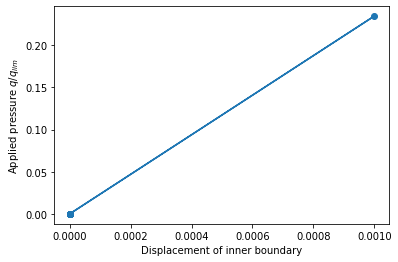

In [52]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()